In [1]:
import gzip
import collections
import numpy as np
import pandas as pd

### CHECK https://github.com/broadinstitute/gtex-pipeline/tree/master/gene_model
### Important for preprocessing the annotation GTF


infile="/cbscratch/franco/datasets/gtex_v8/gencode.v26.collapsed.genes.gtf"
outfile="/cbscratch/franco/datasets/gtex_v8/gencode.v26.coding_lengths"

l = 0
genedict = collections.defaultdict(dict)
lead_transcripts = dict()
with open(infile) as instream:
    for line in instream:
        if line.startswith("#"):
            continue
        arr = line.strip().split("\t")
        chrm = arr[0]
        etype = arr[2]
        start = int(arr[3])
        end = int(arr[4])
        annots = arr[8].split(";")
        gene_id = annots[0].split()[1][1:-1]
        if etype == "gene":
            genedict[gene_id]["length"] = end - start + 1
        if etype == "exon":
            for aa in annots:
                if aa.startswith(" transcript_id"):
                    t_id = aa.split()[1][1:-1]
                    if t_id in genedict[gene_id]:
                        genedict[gene_id][t_id] += end - start + 1
                    else:
                        genedict[gene_id][t_id] = end - start + 1
                        lead_transcripts[gene_id] = t_id
                    break
        l += 1
#         if l > 20:
#             break

In [2]:
with open(outfile, 'w') as outstream:
    for i, gene in enumerate(lead_transcripts.keys()):
        t_id = lead_transcripts[gene]
        t_length = genedict[gene][t_id]
        outstream.write("{:s}\t{:d}\n".format(gene, t_length))


In [4]:
lengthsfile = outfile
gene_len_dict = dict()

with open(lengthsfile) as instream:
    for line in instream:
        arr = line.rstrip().split()
        gene_len_dict[arr[0].split(".")[0]] = int(arr[1])

In [6]:
gtex_v8_reads = "/cbscratch/franco/datasets/gtex_v8/expression/phASER_GTEx_v8_matrix_collapsed_counts_fix.txt.gz"
reads = pd.read_csv(gtex_v8_reads, header=0, sep="\t")

In [8]:
reads.head()

,name,GTEX-14A6H-2726-SM-5QGPL,GTEX-14A6H-0226-SM-5Q5DX,GTEX-14A6H-2426-SM-5Q5BO,GTEX-14A6H-2026-SM-5Q5DD,GTEX-14A6H-0526-SM-5NQAZ,GTEX-14A6H-0006-SM-5NQ7W,GTEX-14A6H-1326-SM-5NQBC,GTEX-14A6H-2626-SM-5NQBO,GTEX-14A6H-0326-SM-5NQAN,...,GTEX-16YQH-0011-R6b-SM-7938T,GTEX-16YQH-0011-R3a-SM-7EPGM,GTEX-16YQH-3126-SM-79OJZ,GTEX-16YQH-0011-R10b-SM-7LT8U,GTEX-16YQH-0011-R7a-SM-79ON1,GTEX-16YQH-0011-R5b-SM-7938U,GTEX-16YQH-0426-SM-7KUL7,GTEX-16YQH-2226-SM-7IGM2,GTEX-16YQH-0011-R4a-SM-7EPGI,GTEX-16YQH-2826-SM-6PAMY
0,ENSG00000223972.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000227232.5,62,117,231,197,212,74,220,164,88,...,39,53,61,77,42,21,65,193,53,100
2,ENSG00000278267.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000243485.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000237613.2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
ix = list()
genenames = [x.split(".")[0] for x in list(reads.name)]
for name in genenames:
    if name in gene_len_dict:
        ix.append(True)
    else:
        ix.append(False)

geneix = np.where(ix)[0]
filtered_genenames = [genenames[i] for i in geneix]
genelengths = np.array([gene_len_dict[x] for x in filtered_genenames])

In [19]:
filtered_reads = reads.iloc[np.array(ix)]
TPM_matrix = np.zeros((filtered_reads.shape[0], filtered_reads.shape[1]-1))
for i in range(1, filtered_reads.shape[1]):
    rpk = filtered_reads.iloc[:, i] * 1000 / genelengths
    sf = np.sum(rpk) / 1000000
    tpm = rpk / sf
    TPM_matrix[:,i-1] = tpm
    if i%1000 == 0:
        print("Processed {:d} samples".format(i))

Processed 1000 samples
Processed 2000 samples
Processed 3000 samples
Processed 4000 samples
Processed 5000 samples
Processed 6000 samples
Processed 7000 samples
Processed 8000 samples
Processed 9000 samples
Processed 10000 samples
Processed 11000 samples
Processed 12000 samples
Processed 13000 samples
Processed 14000 samples
Processed 15000 samples


In [20]:
filtered_reads.head()

,name,GTEX-14A6H-2726-SM-5QGPL,GTEX-14A6H-0226-SM-5Q5DX,GTEX-14A6H-2426-SM-5Q5BO,GTEX-14A6H-2026-SM-5Q5DD,GTEX-14A6H-0526-SM-5NQAZ,GTEX-14A6H-0006-SM-5NQ7W,GTEX-14A6H-1326-SM-5NQBC,GTEX-14A6H-2626-SM-5NQBO,GTEX-14A6H-0326-SM-5NQAN,...,GTEX-16YQH-0011-R6b-SM-7938T,GTEX-16YQH-0011-R3a-SM-7EPGM,GTEX-16YQH-3126-SM-79OJZ,GTEX-16YQH-0011-R10b-SM-7LT8U,GTEX-16YQH-0011-R7a-SM-79ON1,GTEX-16YQH-0011-R5b-SM-7938U,GTEX-16YQH-0426-SM-7KUL7,GTEX-16YQH-2226-SM-7IGM2,GTEX-16YQH-0011-R4a-SM-7EPGI,GTEX-16YQH-2826-SM-6PAMY
0,ENSG00000223972.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000227232.5,62,117,231,197,212,74,220,164,88,...,39,53,61,77,42,21,65,193,53,100
2,ENSG00000278267.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000243485.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000237613.2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
tpm_df = pd.DataFrame(TPM_matrix, index=filtered_reads.name, columns=filtered_reads.columns[1:])
tpm_df.head()

,GTEX-14A6H-2726-SM-5QGPL,GTEX-14A6H-0226-SM-5Q5DX,GTEX-14A6H-2426-SM-5Q5BO,GTEX-14A6H-2026-SM-5Q5DD,GTEX-14A6H-0526-SM-5NQAZ,GTEX-14A6H-0006-SM-5NQ7W,GTEX-14A6H-1326-SM-5NQBC,GTEX-14A6H-2626-SM-5NQBO,GTEX-14A6H-0326-SM-5NQAN,GTEX-14A6H-2326-SM-5Q5B5,...,GTEX-16YQH-0011-R6b-SM-7938T,GTEX-16YQH-0011-R3a-SM-7EPGM,GTEX-16YQH-3126-SM-79OJZ,GTEX-16YQH-0011-R10b-SM-7LT8U,GTEX-16YQH-0011-R7a-SM-79ON1,GTEX-16YQH-0011-R5b-SM-7938U,GTEX-16YQH-0426-SM-7KUL7,GTEX-16YQH-2226-SM-7IGM2,GTEX-16YQH-0011-R4a-SM-7EPGI,GTEX-16YQH-2826-SM-6PAMY
name,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232.5,100.007751,120.706046,314.767675,230.656127,175.613658,78.625414,178.906676,196.700368,68.724458,283.996529,...,86.067584,70.391682,57.169618,93.458928,93.153272,39.136054,60.138938,111.345495,72.496947,69.513745
ENSG00000278267.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000243485.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
tpm_df.to_csv("/cbscratch/franco/datasets/gtex_v8/expression/TPMs_phASER_GTEx_v8.matrix.txt", header=True, sep="\t")

### Check if it works on GTEx v7


In [150]:
### Check if it works on GTEx v7

reads = pd.read_csv("read_extract.txt", sep="\t", header=0)
tpms  = pd.read_csv("tpm_extract.txt", sep="\t", header=0)
tpms.head()

,Name,Description,GTEX-1117F-0226-SM-5GZZ7,GTEX-111CU-1826-SM-5GZYN,GTEX-111FC-0226-SM-5N9B8,GTEX-111VG-2326-SM-5N9BK,GTEX-111YS-2426-SM-5GZZQ,GTEX-1122O-2026-SM-5NQ91,GTEX-1128S-2126-SM-5H12U,GTEX-113IC-0226-SM-5HL5C
0,ENSG00000223972.4,DDX11L1,0.10820,0.11580,0.02104,0.02329,0.00000,0.04641,0.03076,0.09358
1,ENSG00000227232.4,WASH7P,21.40000,11.03000,16.75000,8.17200,7.65800,9.37200,10.08000,13.56000
2,ENSG00000243485.2,MIR1302-11,0.16020,0.06433,0.04674,0.00000,0.05864,0.00000,0.13670,0.20790
3,ENSG00000237613.2,FAM138A,0.05045,0.00000,0.02945,0.03260,0.00000,0.00000,0.08610,0.13100
4,ENSG00000268020.2,OR4G4P,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.11080,0.05619


In [151]:
ix = list()
genenames = [x.split(".")[0] for x in list(reads.Name)]
for name in genenames:
    if name in gene_len_dict:
        ix.append(True)
    else:
        ix.append(False)

geneix = np.where(ix)[0]
filtered_genenames = [genenames[i] for i in geneix]
genelengths = np.array([gene_len_dict[x] for x in filtered_genenames])

In [157]:
filtered_reads = reads.iloc[np.array(ix)]
rpk = filtered_reads.iloc[:, 2] * 1000 / genelengths
sf = np.sum(rpk) / 1000000
print(rpk / sf)

0            0.108152
1           21.404305
2            0.160163
3            0.050453
4            0.000000
5            0.000000
6            0.000000
7            0.239194
8            0.186938
9            9.467460
10           0.000000
11           0.952053
12           0.565884
13           0.000000
14           0.134579
15           0.921653
16           0.206654
17           0.237462
18           0.125516
19           0.000000
20           0.000000
21           0.000000
22           0.000000
23           0.000000
24           0.272941
25           0.479241
26           0.073044
27           0.000000
28           0.000000
29           0.145225
             ...     
56172        0.891342
56173        0.000000
56174     9402.642466
56175        0.904450
56176        2.674027
56177        1.685004
56178        3.784777
56179       10.408137
56180    10659.299183
56181       62.393972
56182        0.000000
56183    11586.502025
56184        0.878609
56185    10599.462556
56186    1

In [158]:
tpms.head()

,Name,Description,GTEX-1117F-0226-SM-5GZZ7,GTEX-111CU-1826-SM-5GZYN,GTEX-111FC-0226-SM-5N9B8,GTEX-111VG-2326-SM-5N9BK,GTEX-111YS-2426-SM-5GZZQ,GTEX-1122O-2026-SM-5NQ91,GTEX-1128S-2126-SM-5H12U,GTEX-113IC-0226-SM-5HL5C
0,ENSG00000223972.4,DDX11L1,0.10820,0.11580,0.02104,0.02329,0.00000,0.04641,0.03076,0.09358
1,ENSG00000227232.4,WASH7P,21.40000,11.03000,16.75000,8.17200,7.65800,9.37200,10.08000,13.56000
2,ENSG00000243485.2,MIR1302-11,0.16020,0.06433,0.04674,0.00000,0.05864,0.00000,0.13670,0.20790
3,ENSG00000237613.2,FAM138A,0.05045,0.00000,0.02945,0.03260,0.00000,0.00000,0.08610,0.13100
4,ENSG00000268020.2,OR4G4P,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.11080,0.05619


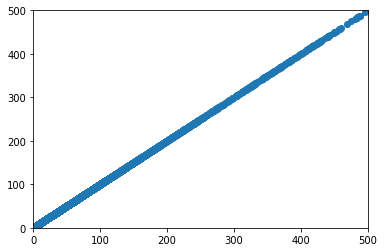

In [159]:
import matplotlib.pyplot as plt
x = tpms.iloc[np.array(ix), 2]
y = rpk/sf
plt.scatter( x, y)
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()